In [2]:
# importing packs
import numpy as np
import pandas as pd
import glob 
import matplotlib.pyplot as plt

# reading data and creating dataframe

DATA_PATH = 'data/PhysicalFlows_12.1.G/*.csv'

files = glob.glob(DATA_PATH)
df_flow_all = pd.concat([pd.read_csv(file, sep = '\t') for file in files], ignore_index = True )



In [3]:
# making sure the date and times are in order



df_flow_all['DateTime'] = pd.to_datetime(df_flow_all['DateTime'])

df_flow_all = df_flow_all.set_index('DateTime')

df_flow_all = df_flow_all.sort_index()



df_flow_all

,InMapCode,OutMapCode,FlowValue
DateTime,,,
2019-01-01 00:00:00,AL,GR,173.00
2019-01-01 00:00:00,SE,DE_TenneT_GER,1.60
2019-01-01 00:00:00,DE,PL,0.00
2019-01-01 00:00:00,SE,DE,1.60
2019-01-01 00:00:00,DE,SE,0.00
...,...,...,...
2023-12-31 23:00:00,GB,NIE,121.70
2023-12-31 23:00:00,GB,IE_SEM,121.70
2023-12-31 23:00:00,SI,HU,250.29


In [4]:
#reseting index for later use

df_flow_all = df_flow_all.reset_index()

# filtering norway to germany 
imports = df_flow_all[(df_flow_all['InMapCode'] == 'NO2') & (df_flow_all['OutMapCode'] == 'DE_LU')]



# filtering germany to norway

exports = df_flow_all[(df_flow_all['InMapCode'] == 'DE_LU') & (df_flow_all['OutMapCode'] == 'NO2')]

df_flow_all


,DateTime,InMapCode,OutMapCode,FlowValue
0,2019-01-01 00:00:00,AL,GR,173.00
1,2019-01-01 00:00:00,SE,DE_TenneT_GER,1.60
2,2019-01-01 00:00:00,DE,PL,0.00
3,2019-01-01 00:00:00,SE,DE,1.60
4,2019-01-01 00:00:00,DE,SE,0.00
...,...,...,...,...
14402341,2023-12-31 23:00:00,GB,NIE,121.70
14402342,2023-12-31 23:00:00,GB,IE_SEM,121.70
14402343,2023-12-31 23:00:00,SI,HU,250.29
14402344,2023-12-31 23:00:00,GE,AM,0.00


In [5]:
# converting norway to germany dataframe to weekly

exports['DateTime'] = pd.to_datetime(exports['DateTime'])

exports_W = exports.pivot_table(index=[pd.Grouper(key = 'DateTime', freq = 'W'), 'InMapCode', 'OutMapCode'], values = 'FlowValue', aggfunc='sum').reset_index()
exports_W

C:\Users\oleth\AppData\Local\Temp\ipykernel_23124\4274326297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exports['DateTime'] = pd.to_datetime(exports['DateTime'])


,DateTime,InMapCode,OutMapCode,FlowValue
0,2020-09-06,DE_LU,NO2,416.5650
1,2020-09-13,DE_LU,NO2,49.3525
2,2020-09-20,DE_LU,NO2,251.7025
3,2020-09-27,DE_LU,NO2,493.4625
4,2020-10-04,DE_LU,NO2,1611.9525
...,...,...,...,...
169,2023-12-03,DE_LU,NO2,37466.2400
170,2023-12-10,DE_LU,NO2,46808.3600
171,2023-12-17,DE_LU,NO2,85028.6400
172,2023-12-24,DE_LU,NO2,41917.1025


In [6]:
#converting germany to norway dataframe to weekly

imports_W = imports.pivot_table(index=[pd.Grouper(key = 'DateTime', freq = 'W'), 'InMapCode', 'OutMapCode'], values = 'FlowValue', aggfunc='sum').reset_index()
imports_W

,DateTime,InMapCode,OutMapCode,FlowValue
0,2020-09-06,NO2,DE_LU,301.5225
1,2020-09-13,NO2,DE_LU,1210.3850
2,2020-09-20,NO2,DE_LU,76.7000
3,2020-09-27,NO2,DE_LU,121.0250
4,2020-10-04,NO2,DE_LU,1524.2600
...,...,...,...,...
169,2023-12-03,NO2,DE_LU,22251.4950
170,2023-12-10,NO2,DE_LU,63249.6975
171,2023-12-17,NO2,DE_LU,11020.3850
172,2023-12-24,NO2,DE_LU,129764.6625


In [7]:
# merging the two dataframes


merged_df = pd.merge(exports_W, imports_W, on = ['DateTime'], suffixes = ('_export', '_import'))



merged_df.fillna(0, inplace= True) # removing NaNs

print(merged_df.head())

# creating netflow column
merged_df['NetFlow'] = merged_df['FlowValue_export'] - merged_df['FlowValue_import']

print(merged_df.head())



    DateTime InMapCode_export OutMapCode_export  FlowValue_export  \
0 2020-09-06            DE_LU               NO2          416.5650   
1 2020-09-13            DE_LU               NO2           49.3525   
2 2020-09-20            DE_LU               NO2          251.7025   
3 2020-09-27            DE_LU               NO2          493.4625   
4 2020-10-04            DE_LU               NO2         1611.9525   

  InMapCode_import OutMapCode_import  FlowValue_import  
0              NO2             DE_LU          301.5225  
1              NO2             DE_LU         1210.3850  
2              NO2             DE_LU           76.7000  
3              NO2             DE_LU          121.0250  
4              NO2             DE_LU         1524.2600  
    DateTime InMapCode_export OutMapCode_export  FlowValue_export  \
0 2020-09-06            DE_LU               NO2          416.5650   
1 2020-09-13            DE_LU               NO2           49.3525   
2 2020-09-20            DE_LU       

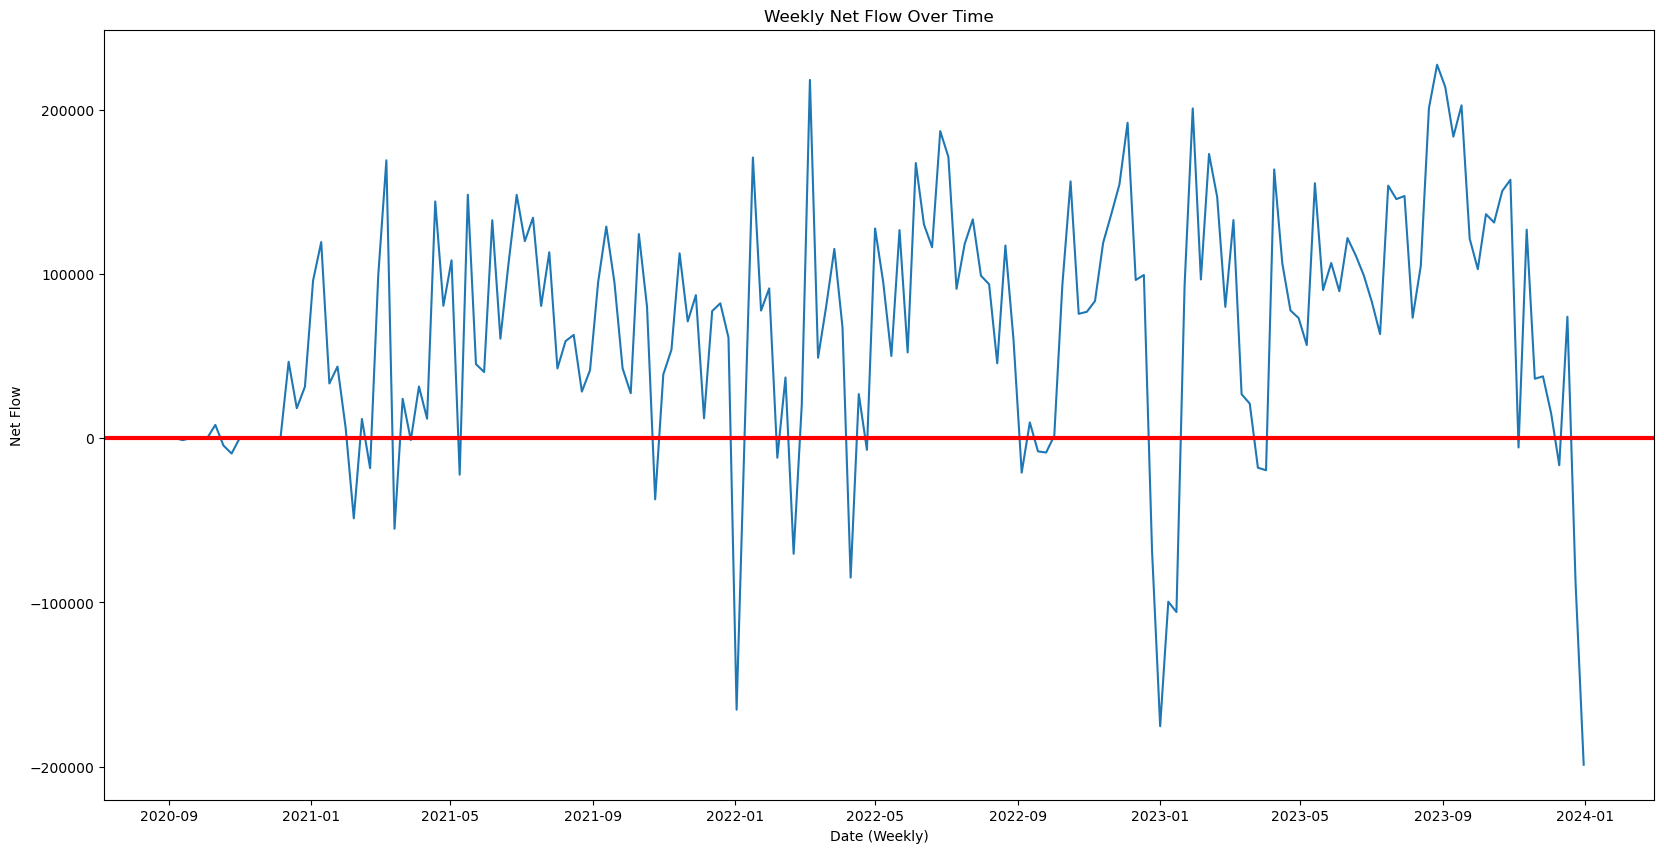

In [8]:
# ensuring merged dataframe is in datetime format
merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])

# plotting the graph and adding labels

plt.figure(figsize = (20,10))

plt.plot(merged_df['DateTime'], merged_df['NetFlow'], linestyle = '-')

plt.title('Weekly Net Flow Over Time')
plt.xlabel('Date (Weekly)')
plt.ylabel('Net Flow')
plt.axhline(color = 'red', linewidth = 3)
plt.show()


TASK 4 CONCLUSION

The graph shows that NO2 is a net exporter of electricity for the vast majority of the weeks from 2020 to the end of 2023. however, it also indicates that at certain times of the year NO2 imported more electricity than it exported (indicated by the negative spikes). The pattern shows that NO2 imports more electricity between the last month of the year and the first 5 months of the following year. A possibe explanation for this pattern is that during the winter, rivers tend to slow down or stop flowing. Therefore, since the majority of electricity produced in norway comes from hydropower (dependant on waterflow), the production of electricity during this period is decreased and NO2 has to depend on the import of electricity to sustain itself.